#  Model #2b – použití rozmazávání pozadí a Houghovy transformace

---



# Importy

In [33]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.transform import probabilistic_hough_line

import glob
import matplotlib.cm as cm
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Načtení obrázku

Na obrázku musí být jen jedna strana kostky. Kostka musí být rovně, v přiměřené vzdálenosti a musí být vidět všechny okraje. Pokud je nutné zanedbat pozadí (nehomogenní pozadí) pomocí rozmazání, tak je potřeba, aby kostka byla uprostřed.

Obrázek je přeškálován na čtverec o velikosti *size* - potřebné, protože následně *probabilistic_hough_line* hledá přímky s pevně danou délkou.

In [17]:
def load_image(image_path, size=(600, 600)):
    image_rgb = imread(image_path)
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
    resized = cv2.resize(image_bgr, size)
    return resized

## Rozmazání okrajů - volitelné

Pokus o zanedbání pozadí - rozmazání okrajů obrázku tak, aby tam nešly najít přímky. \
V kalibraci se dá vypnout, nebo zapnout.

In [18]:
def blur_image_sides(image, blur_size=21, margin=100):
    h, w = image.shape[:2]
    blurred = cv2.GaussianBlur(image, (blur_size, blur_size), 0)

    mask = np.zeros((h, w), dtype=np.float32)
    mask[margin:h - margin, margin:w - margin] = 1.0

    mask = cv2.GaussianBlur(mask, (blur_size-100, blur_size-100), 0)    # přechod mezi rozmazanou a nerozmazanou částí - jinak to považuje za hranu
    mask_3ch = np.dstack([mask] * 3)

    output = (image * mask_3ch + blurred * (1 - mask_3ch)).astype(np.uint8)
    return output

## Hledání úseček

Funkce *find_grid_lines* najde úsečky pomocí *canny* a *probabilistic_hough_line*. Parametry v těchto funkcích silně závisí na podmínkách (osvětlení, ostrost obrázku, vzdálenost kostky od obrázku).

Ačkoliv by se zdálo, že nejpraktičtější bude hledat úsečky jako celé hrany kostky, ukázalo se, že to není dosažitelné (zřejmě proto, že hrany jednotlivých čtverců jsou zaoblené), takže parametr *line_length* musí být poměrně malý (pro naše obrázky 20-70). Problém však je, že pokud jsou na pozadí rovné čáry, tak jsou považovány za součást kostky, i když nejsou. To by se s větším *line_length* zřejmě zlepšilo.

Funkce *parallel_lines* nalezne, které úsečky svírají určitý úhel s okrajem obrázku. Tím se dají odfiltrovat úsečky, které nenáleží kostce.

In [19]:
# Najít rovné čáry
def find_grid_lines(image):
    gray = rgb2gray(image)

    # Nalezení křivek v obrázku
    edges = canny(gray, sigma=2, low_threshold=0.05, high_threshold=0.5)

    # Houghova transformace - nalezení přímek
    lines = probabilistic_hough_line(edges, threshold=5, line_length=30, line_gap=5)

    # Nalezení rovnoběžných přímek
    h_lines = parallel_lines(lines, (80, 100))
    v_lines = parallel_lines(lines, (0, 10)) + parallel_lines(lines, (170, 180))

    return h_lines, v_lines

# Odfiltrování nerovnoběžných přímek
def parallel_lines(lines, angle_range):
    parallel_lines = []

    for p0, p1 in lines:
        angle = np.degrees(np.arctan2(p1[1] - p0[1], p1[0] - p0[0])) % 180
        if angle_range[0] <= angle <= angle_range[1]:
            parallel_lines.append((p0, p1))
    return parallel_lines

## Hledání průsečíků

Funkcí *to_params* se najde parametrizace přímky pro každou nalezenou úsečku a následně se funkcí *line_intersection* nalezne průnik těchto přímek. Pomocí funkce *unique_intersections* se odfiltrují přebytečné průsečíky způsobené duplikátními přímkami - projdou se všechny dvojice průsečíků, a když jsou k sobě moc blízko, tak se zprůměrují. Výsledné průsečíky se seřadí shora zleva dolů doprava. Seřazení je nutné pro následné hledání barev, protože tam se operuje se souřadnicemi rohů jednotlivých čtverců.

In [20]:
# Výpočet přímky Ax + By = C ze dvou bodů
def to_params(p0, p1):
    A = p1[1] - p0[1]
    B = p0[0] - p1[0]
    C = A * p0[0] + B * p0[1]
    return A, B, C

# Nalezení průsečíků přímek
def line_intersection(line1, line2):

    # Nalezení rovnic přímek pro obě přímky.
    A1, B1, C1 = to_params(*line1)
    A2, B2, C2 = to_params(*line2)

    det = A1 * B2 - A2 * B1

    # Souřadnice průsečíku.
    x = (B2 * C1 - B1 * C2) / det
    y = (A1 * C2 - A2 * C1) / det
    return (int(x), int(y))

# Nalezení unikátních průsečíků.
def unique_intersections(h_lines, v_lines, min_dist=40):

    inter_points = []

    # Najít všechny průniky horizonálních a vertikálních přímek.
    for h in h_lines:
        for v in v_lines:
            pt = line_intersection(h, v)
            if pt:
                inter_points.append(pt)

    # Odstranění duplikátů.
    unique = []
    for pt in inter_points:
        found = False
        for idx, u in enumerate(unique):
            if np.linalg.norm(np.array(pt) - np.array(u)) < min_dist:
                # Blízké průsečíky se zprůměrují.
                unique[idx] = (
                    int((u[0] + pt[0]) / 2),
                    int((u[1] + pt[1]) / 2)
                )
                found = True
                break
        if not found:
            unique.append(pt)

    return unique

# Seřazení průsečíků podle souřadnic – shora-dolů, zleva-doprava
def sort_points_grid(points):

    points = sorted(points, key=lambda p: (p[1], p[0]))

    rows = []
    current_row = []
    last_y = None

    for pt in points:
        if last_y is None or abs(pt[1] - last_y) < 40:
            current_row.append(pt)
            last_y = pt[1] if last_y is None else (last_y + pt[1]) / 2
        else:
            rows.append(sorted(current_row, key=lambda p: p[0]))
            current_row = [pt]
            last_y = pt[1]

    if current_row:
        rows.append(sorted(current_row, key=lambda p: p[0]))

    ordered_points = [pt for row in rows for pt in row]
    return ordered_points

Vykreslení úseček a průsečíků:

In [21]:
# Vykreslení
def plot_lines_and_points(image, h_lines, v_lines, points):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Vykreslení čar
    for p0, p1 in h_lines + v_lines:
        ax.plot([p0[0], p1[0]], [p0[1], p1[1]], color='cyan', linewidth=1)

    # Vykreslení bodů
    for idx, (x, y) in enumerate(points):
        color = "red"
        ax.plot(x, y, 'o', color=color, markersize=3)
        ax.text(x + 5, y - 5, str(idx), color=color, fontsize=5)  # Indexy rohových bodů

    ax.axis("off")
    plt.show()

# Rozmazání (volitelné)

Začne s rozmazaným obrázkem a postupně od středu ubírá rozmazání, dokud nebude možné najít přesně 16 průsečíků.

In [22]:
def try_blur_until_grid_found(image, blur_size=201, start_margin=300, end_margin=10, step=10, plot_blurred=False):
    for marg in range(start_margin, end_margin, -step):
        print(f"Trying with margin: {marg}")
        blurred = blur_image_sides(image, blur_size=blur_size, margin=marg)

        h_lines, v_lines = find_grid_lines(blurred)
        intersections = unique_intersections(h_lines, v_lines)
        ordered_points = sort_points_grid(intersections)

        print(f"Found {len(ordered_points)} intersections.")

        if plot_blurred:
          plot_lines_and_points(blurred, h_lines, v_lines, ordered_points)

        if len(ordered_points) == 16:
            print(f"Found 16 intersections at margin {marg}.\n")
            return blurred, ordered_points

    print("Didn't find 16 intersections with any blur.")
    return None, None

Tento kód provede v pořadí předchozí funkce.

In [23]:
def pipeline(image_path, blur_background=True, plot_blurred=False):
    image_rgb = imread(image_path)
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
    resized = cv2.resize(image_bgr, (600, 600))

    if blur_background:
        return try_blur_until_grid_found(resized, plot_blurred=plot_blurred)
    else:
        print("Running on non-blurred image...")
        h_lines, v_lines = find_grid_lines(resized)
        intersections = unique_intersections(h_lines, v_lines)
        ordered_points = sort_points_grid(intersections)

        print(f"Found {len(ordered_points)} intersections.")

        plot_lines_and_points(resized, h_lines, v_lines, ordered_points)

        if len(ordered_points) == 16:
            print("Found 16 intersections.\n")
            return resized, ordered_points
        else:
            print("Didn't find 16 intersections.")
            return None, None

## Určení barev

Funkcí *average_color_between_points* se vypočítá průměrná barva mezi čtyřmi body - do funkce se vkládají čtyři průsečíky tvořící čtverec. Funkce *similar_colors* určí jestli dva čtverce mají stejnou barvu podle toho, zda jsou jejich průměrné barvy od sebe málo vzdálené.

In [24]:
# vypocet prumerne barvy mezi ctyrmi body
def average_color_between_points(image, points, idx1, idx2, idx3, idx4):
    pts = np.array([points[idx1], points[idx2], points[idx4], points[idx3]], dtype=np.int32)
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [pts], 255)
    mean_color = cv2.mean(image, mask=mask)[:3]  # BGR

    return mean_color

def similar_colors(color1, color2, threshold=50):
    diff = np.linalg.norm(np.array(color1) - np.array(color2))
    return diff < threshold

def compare_square_colors(image, points):
    # vypocitat barvy vsech ctvercu
    colors = {
        'top_left': average_color_between_points(image, points, 0, 1, 4, 5),
        'top_middle': average_color_between_points(image, points, 1, 2, 5, 6),
        'top_right': average_color_between_points(image, points, 2, 3, 6, 7),
        'middle_left': average_color_between_points(image, points, 4, 5, 8, 9),
        'middle': average_color_between_points(image, points, 5, 6, 9, 10),
        'middle_right': average_color_between_points(image, points, 6, 7, 10, 11),
        'bottom_left': average_color_between_points(image, points, 8, 9, 12, 13),
        'bottom_middle': average_color_between_points(image, points, 9, 10, 13, 14),
        'bottom_right': average_color_between_points(image, points, 10, 11, 14, 15)
    }

    # Porovnat každý čtverec s každým
    unsolved = 0
    keys = list(colors.keys())
    for i in range(len(keys)):
        for j in range(i + 1, len(keys)):
            color1 = colors[keys[i]]
            color2 = colors[keys[j]]
            if not similar_colors(color1, color2):
                unsolved += 1
    if unsolved == 0:
        return 0
    return 1

def classify_color(rgb):
    color_refs = {
    "white":  (240, 240, 240),
    "yellow": (60, 230, 250),
    "red":    (80, 32, 255),
    "orange": (0, 120, 255),
    "green":  (60, 180, 30),
    "blue":   (170, 70, 20),
    }

    min_dist = float('inf')
    best_match = None
    for name, ref_rgb in color_refs.items():
        dist = np.linalg.norm(np.array(rgb) - np.array(ref_rgb))
        if dist < min_dist:
            min_dist = dist
            best_match = name

    return best_match

def get_colors(image, points):
    # Vypočítat barvy všech čtverců
    colors = {
        'top_left': average_color_between_points(image, points, 0, 1, 4, 5),
        'top_middle': average_color_between_points(image, points, 1, 2, 5, 6),
        'top_right': average_color_between_points(image, points, 2, 3, 6, 7),
        'middle_left': average_color_between_points(image, points, 4, 5, 8, 9),
        'middle': average_color_between_points(image, points, 5, 6, 9, 10),
        'middle_right': average_color_between_points(image, points, 6, 7, 10, 11),
        'bottom_left': average_color_between_points(image, points, 8, 9, 12, 13),
        'bottom_middle': average_color_between_points(image, points, 9, 10, 13, 14),
        'bottom_right': average_color_between_points(image, points, 10, 11, 14, 15)
    }

    color_matrix = np.zeros([3, 3], dtype=object)

    for idx, (name, rgb) in enumerate(colors.items()):
        i = idx // 3
        j = idx % 3
        color_matrix[i][j] = classify_color(rgb)

    return color_matrix

def square_center(points, idx1, idx2, idx3, idx4):
    x = ((points[idx1][0] + points[idx2][0] + points[idx3][0] + points[idx4][0]) // 4) - 15
    y = (points[idx1][1] + points[idx2][1] + points[idx3][1] + points[idx4][1]) // 4
    return (x, y)

def label_squares_with_colors(image, points, color_matrix):
    labeled_img = image.copy()

    square_indices = [
        (0, 1, 4, 5),   # top-left
        (1, 2, 5, 6),   # top-middle
        (2, 3, 6, 7),   # top-right
        (4, 5, 8, 9),   # middle-left
        (5, 6, 9, 10),  # middle
        (6, 7, 10, 11), # middle-right
        (8, 9, 12, 13), # bottom-left
        (9, 10, 13, 14),# bottom-middle
        (10, 11, 14, 15)# bottom-right
    ]

    for idx, idxs in enumerate(square_indices):
        i = idx // 3
        j = idx % 3
        color_name = color_matrix[i][j]
        center = square_center(points, *idxs)

        cv2.putText(
            labeled_img,
            color_name,
            center,
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 0, 0),
            2,
            cv2.LINE_AA
        )

    return labeled_img

Tento kód provede všechno předchozí:

In [25]:
def run_all(image_path, blur=False, show=False):
    image, points = pipeline(image_path, blur_background=blur, plot_blurred=show)

    if image is None or points is None:
        return 1

    color_matrix = get_colors(image, points)

    plt.figure(figsize=(4,0.3))
    plt.text(0,0, f'Side color: {color_matrix[1][1]}', fontsize=10, color='black')
    plt.axis('off')
    plt.show()

    labeled_image = label_squares_with_colors(image, points, color_matrix)
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    unsolved = compare_square_colors(image, points)
    msg = "solved" if unsolved == 0 else "unsolved"
    color = "black" if unsolved == 0 else "red"

    plt.figure(figsize=(4, 0.3))
    plt.text(0, 0, f"Side: {msg}", fontsize=10, color=color)
    plt.axis('off')
    plt.show()
    return unsolved


# Spuštění

### Cesta ke složce s fotkami (GitHub):

Na obrázku musí být jen jedna strana kostky. Kostka musí být rovně, v přiměřené vzdálenosti a musí být vidět všechny okraje. Pokud je nutné zanedbat pozadí pomocí rozmazání, tak je potřeba, aby kostka byla uprostřed.

In [37]:
# Naklonování repozitáře
!git clone https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/

image_paths = glob.glob("Rozpoznavani-Rubikovy-kostky/data_klasicky_model/rozlozena_kostka/*.jpg")

fatal: destination path 'Rozpoznavani-Rubikovy-kostky' already exists and is not an empty directory.
['Rozpoznavani-Rubikovy-kostky/data_klasicky_model/rozlozena_kostka/20250527_095022.jpg', 'Rozpoznavani-Rubikovy-kostky/data_klasicky_model/rozlozena_kostka/20250527_095103.jpg', 'Rozpoznavani-Rubikovy-kostky/data_klasicky_model/rozlozena_kostka/20250527_095009.jpg', 'Rozpoznavani-Rubikovy-kostky/data_klasicky_model/rozlozena_kostka/20250527_095039.jpg', 'Rozpoznavani-Rubikovy-kostky/data_klasicky_model/rozlozena_kostka/20250527_095033.jpg', 'Rozpoznavani-Rubikovy-kostky/data_klasicky_model/rozlozena_kostka/20250527_095047.jpg']


### Parametry

Když je parametr *blur_background* nastaven na True, potom každý obrázek začne zcela rozmazaný a poté se iterativně od středu obrázku rozmazání ubírá, dokud nebude nalezeno přesně 16 průsečíků. Jinak se operuje jen s ostrým obrázkem.

Když je parametr *show_blurred* True, tak se postupně zobrazí všechny iterace rozmazání. Jinak se zobrazí jen konečný stav.

Na obrázky s přímkami na pozadí to s rozmazáním funguje lépe než bez něj, ale tato metoda není příliš spolehlivá a navíc vyžaduje, aby kostka byla uprostřed obrázku. Rozmazání navíc někdy způsobuje, že žlutá je rozpoznaná jako oranžová.

In [29]:
blur_background = True
show_blurred = False

## Main:

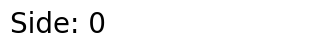

Trying with margin: 300
Found 0 intersections.
Trying with margin: 290
Found 0 intersections.
Trying with margin: 280
Found 0 intersections.
Trying with margin: 270
Found 0 intersections.
Trying with margin: 260
Found 0 intersections.
Trying with margin: 250
Found 0 intersections.
Trying with margin: 240
Found 4 intersections.
Trying with margin: 230
Found 4 intersections.
Trying with margin: 220
Found 4 intersections.
Trying with margin: 210
Found 4 intersections.
Trying with margin: 200
Found 4 intersections.
Trying with margin: 190
Found 4 intersections.
Trying with margin: 180
Found 4 intersections.
Trying with margin: 170
Found 4 intersections.
Trying with margin: 160
Found 6 intersections.
Trying with margin: 150
Found 9 intersections.
Trying with margin: 140
Found 12 intersections.
Trying with margin: 130
Found 16 intersections.
Found 16 intersections at margin 130.



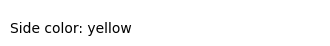

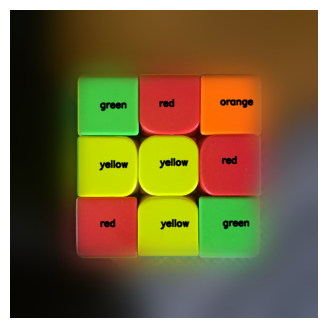

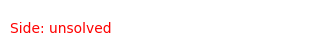

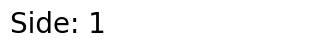

Trying with margin: 300
Found 0 intersections.
Trying with margin: 290
Found 0 intersections.
Trying with margin: 280
Found 0 intersections.
Trying with margin: 270
Found 0 intersections.
Trying with margin: 260
Found 0 intersections.
Trying with margin: 250
Found 4 intersections.
Trying with margin: 240
Found 4 intersections.
Trying with margin: 230
Found 4 intersections.
Trying with margin: 220
Found 16 intersections.
Found 16 intersections at margin 220.



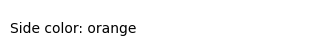

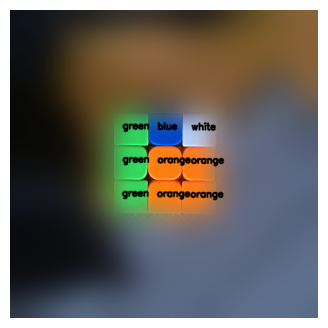

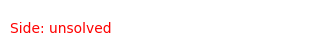

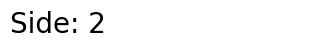

Trying with margin: 300
Found 0 intersections.
Trying with margin: 290
Found 0 intersections.
Trying with margin: 280
Found 0 intersections.
Trying with margin: 270
Found 0 intersections.
Trying with margin: 260
Found 0 intersections.
Trying with margin: 250
Found 4 intersections.
Trying with margin: 240
Found 4 intersections.
Trying with margin: 230
Found 4 intersections.
Trying with margin: 220
Found 4 intersections.
Trying with margin: 210
Found 4 intersections.
Trying with margin: 200
Found 6 intersections.
Trying with margin: 190
Found 8 intersections.
Trying with margin: 180
Found 16 intersections.
Found 16 intersections at margin 180.



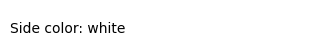

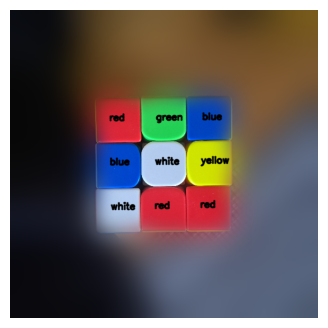

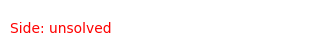

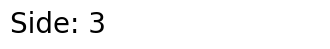

Trying with margin: 300
Found 0 intersections.
Trying with margin: 290
Found 0 intersections.
Trying with margin: 280
Found 0 intersections.
Trying with margin: 270
Found 0 intersections.
Trying with margin: 260
Found 0 intersections.
Trying with margin: 250
Found 0 intersections.
Trying with margin: 240
Found 4 intersections.
Trying with margin: 230
Found 4 intersections.
Trying with margin: 220
Found 4 intersections.
Trying with margin: 210
Found 4 intersections.
Trying with margin: 200
Found 4 intersections.
Trying with margin: 190
Found 12 intersections.
Trying with margin: 180
Found 16 intersections.
Found 16 intersections at margin 180.



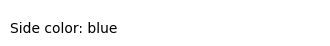

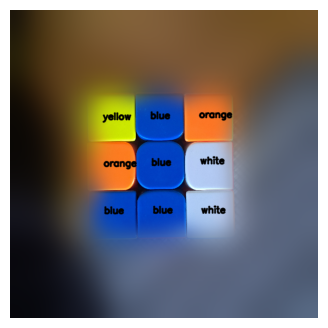

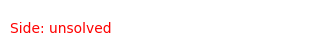

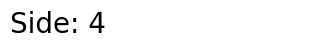

Trying with margin: 300
Found 0 intersections.
Trying with margin: 290
Found 0 intersections.
Trying with margin: 280
Found 0 intersections.
Trying with margin: 270
Found 0 intersections.
Trying with margin: 260
Found 2 intersections.
Trying with margin: 250
Found 4 intersections.
Trying with margin: 240
Found 4 intersections.
Trying with margin: 230
Found 6 intersections.
Trying with margin: 220
Found 12 intersections.
Trying with margin: 210
Found 9 intersections.
Trying with margin: 200
Found 16 intersections.
Found 16 intersections at margin 200.



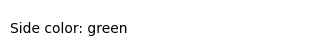

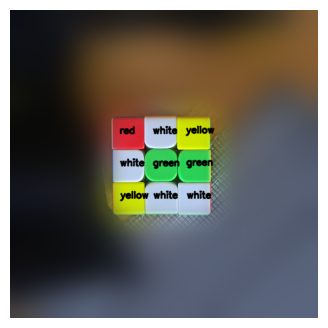

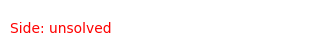

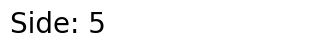

Trying with margin: 300
Found 0 intersections.
Trying with margin: 290
Found 0 intersections.
Trying with margin: 280
Found 0 intersections.
Trying with margin: 270
Found 0 intersections.
Trying with margin: 260
Found 0 intersections.
Trying with margin: 250
Found 1 intersections.
Trying with margin: 240
Found 2 intersections.
Trying with margin: 230
Found 4 intersections.
Trying with margin: 220
Found 4 intersections.
Trying with margin: 210
Found 4 intersections.
Trying with margin: 200
Found 4 intersections.
Trying with margin: 190
Found 9 intersections.
Trying with margin: 180
Found 16 intersections.
Found 16 intersections at margin 180.



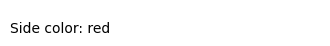

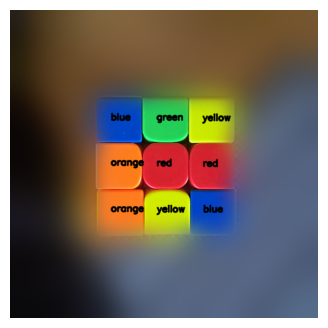

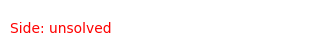

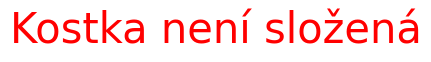

In [38]:
uns = 0
if len(image_paths) > 4 and len(image_paths) < 7:
    for i, path in enumerate(image_paths):
        image_path = path
        plt.figure(figsize=(4,0.3))
        plt.text(0,0, f'Side: {i}', fontsize=20, color='black')
        plt.axis('off')
        plt.show()

        unsolved = run_all(image_path, blur_background, show_blurred)
        uns += unsolved

    if uns == 0:
        plt.figure(figsize=(5,0.3))
        plt.text(0,0, f'Kostka je složená', fontsize=30, color='green')
        plt.axis('off')
        plt.show()
    else:
        plt.figure(figsize=(5,0.3))
        plt.text(0,0, f'Kostka není složená', fontsize=30, color='red')
        plt.axis('off')
        plt.show()

else:
    plt.figure(figsize=(5,0.3))
    plt.text(0,0, f'To není validní kostka!', fontsize=30, color='red')
    plt.axis('off')
    plt.show()